In [158]:
import os
os.getpid()

32012

In [159]:
import json
f = open('ESConv.json')
data = json.load(f)
f.close()
processed_data = []
for i in data:
    pt = i['problem_type']
    if pt == 'Issues with Parents' or pt == 'conflict with parents' or pt == 'Issues with Children':
        processed_data.append(('Issues with Families', i['situation']))
        for j in i['dialog']:
            processed_data.append(('Issues with Families', j['content']))
    elif pt != 'School Bullying' and pt != 'Procrastination' and pt != 'Appearance Anxiety':
        processed_data.append((pt, i['situation']))
        for j in i['dialog']:
            processed_data.append((pt, j['content']))
sl = []
for i in processed_data:
    sl.append(len(i[1].split()))
    
kept = ['problems with friends',
        'ongoing depression',
        'breakup with partner',
        'academic pressure',
        'job crisis',
        'Sleep Problems',
        'Issues with Families',
        'Alcohol Abuse'  ]

filtered_processed_data = []
for i in processed_data:
    if i[0] in kept:
        filtered_processed_data.append(list(i))
        filtered_processed_data[-1][0] = kept.index(filtered_processed_data[-1][0])
import random
random.seed(10)
random.shuffle(filtered_processed_data)
lenth = len(filtered_processed_data)
train_list = filtered_processed_data[0:int(lenth*0.8)]
test_list = filtered_processed_data[int(lenth*0.8):]
from collections import Counter
# Count labels in testing
lts = []
for i in test_list:
    lts.append(i[0])
Counter(lts)

Counter({1: 2144, 0: 1068, 2: 1521, 3: 923, 4: 1686, 6: 183, 5: 172, 7: 69})

In [160]:
def printClass(c):
    for i in processed_data:
        if i[0] == c:
            print(i[1])

In [161]:
printClass('Procrastination')

In [162]:
# Note: remove school Bullying
# Merge 'conflict with parents', 'Issues with Parents', 'Issues with Children'

In [163]:
list4 = []
for i in filtered_processed_data:
    list4.extend(i[1].split(" "))
print(list4[0])

from collections import Counter
import re

c = Counter(list4)

I


In [165]:
c.most_common(1000)[-1]

('news', 60)

In [167]:
# NB: In this version,
# WE ONLY embed for frequent words.
# Other words are all converterted to "N0O0N"
selected = c.most_common(1000)
selected_index_word = []
for i in selected:
    selected_index_word.append(i[0])
selected_index_word[-1]

'news'

In [168]:
# convert to N0O0N
def convert(word_list):
    for i, v in enumerate(word_list):
        if v not in selected_index_word:
            word_list[i] = "N0O0N"
    return word_list

In [169]:
import numpy as np

import torch
from torch.utils.data.sampler import BatchSampler, Sampler
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import random
from tqdm import tqdm

SEED=4321
random.seed(SEED)
np.random.seed(SEED)


class Corpora():
    """
    The class holds training and test corpora.
    """

    def __init__(self):
        """
        Constructor
        """
        # word to index (1-based integers) mapping
        self.word_index = {"N0O0N":0}
        self.index_word = ["N0O0N"]
        # list of reviews tuples, each of which is (sentence_list, rate),
        self.training_reviews = []
        # (sentence_list, rate) Same format as training_sentences
        self.test_reviews = []

        self.max_len = 0


    # input: a tuple (reviewList, rate)
    # todo: insert values into fields
    # Return the list representing all index of words in a review.
    def insert_fields(self, input):   
        # Sentence list
        word_indexes = []
        for word in input:
            if word not in self.word_index.keys():
                self.word_index.update({word:len(self.word_index.keys())}) #No add 1 because 0 is already in
                self.index_word.append(word)
            # find the index of this word, add to return list
            word_indexes.append(self.word_index[word])
        if len(word_indexes)>self.max_len:
            self.max_len = len(word_indexes)
        return word_indexes
    
    
    
    
    # Different than P2, here we 
    def read_corpus(self, is_training):
        if is_training is True:
            target = train_list
        else:
            target = test_list
        print("reading corpus ...")
        for rate, text in tqdm(target):
            input = text.split(" ")
            input = convert(input)
            tuple = (self.insert_fields(input), rate)
            if is_training: 
                self.training_reviews.append(tuple)
            else:
                self.test_reviews.append(tuple)
                    
                
# Inherient Dataset, convert list and int to tensors, load to GPU.
class ReviewRateDataset(Dataset):
   
    def __init__(self, review_rate_pairs): # NB: sequence_pairs is corpora.training_reviews, 
        # list of (sentence_list, rate)
        self.review_rate_pairs = review_rate_pairs

    def __len__(self):
        return len(self.review_rate_pairs)

    def __getitem__(self, idx):
        sentence_list, rate = self.review_rate_pairs[idx] 
        return torch.tensor(sentence_list), torch.tensor(int(rate))

# NB! This class will be in DataLoader function as a parameter for batch_sampler
class SortedBatchSampler(Sampler):
    """
        Each sequence in a mini-batch must of the same lengths, while our sentences
        are of various lengths.
        We can pad the sentences to the same lengths in each mini-batch.
        But if a short and long sentences are in the same mini-batch, more paddings
        are needed.
        We sort the sentences based on their lengths (in descending order)
            and then put sentences with similar lengths in a batch to reduce the paddings.
    """
    def __init__(self, dataset, batch_size):
        """
            dataset: an torch.utils.data.DataSet object containing all training sequences
            batch_size: the number of sequences to put in a mini-batch
        """

        # The sorting and batching go within this function.      
        self.batch_size = batch_size 
        # Sort the dataset (Based on the length of sentence.)
        dataset.review_rate_pairs  = sorted(dataset.review_rate_pairs,key=lambda x:len(x[0]), reverse=True)
        self.sorted_lengths = len(dataset)
        # Batching: Split the dataset into a list of datasets
        self.index_batches = []  
        # -- NB: Collate function does not work, so I pad it directly.
        for i in range(self.__len__()):
            self.index_batches.append(padding_collate_func(ReviewRateDataset(dataset.review_rate_pairs[i*batch_size:i*batch_size+batch_size])))
        # Now, each mini-batches is a ReviewRateDataset object
        # If else format is needed, may change it latter.
        
        
    def __iter__(self):
        """
            return a Python iterator object that iterates the mini-batchs of
                training data indices (not individual indices)
        """
        return iter(self.index_batches)

    def __len__(self):
        return self.sorted_lengths // self.batch_size

# NB! This function will be in DataLoader function as a parameter for collate_fn
def padding_collate_func(batch):
    """
        Transform pairs of input-output sequences in the batch to be of the same length using the function
            torch.nn.utils.rnn.pad_sequence.
        batch: An iterator and each element is a pair of (input_sequence, output_sequence).
        For POS tagging, len(input_sequence) = len(output_sequence). But for different
        pairs in batch, their lengths can differ.

        Example: a batch of 3 pairs of input/output sequences
                [([1,2,3],[1,1,1]), ([1,2,3,4],[2,2,2,2]), ([1,2,3,4,5],[3,3,3,3,3])]
                Note: [] encloses tensors (not numpy arra ys)
                
                
                !!!!!NB QUESTION:  it is the inner [] that encloses tensors, right?
                Comment: Batch is an element of a Sampler (see test_p1.py, a l[0] is a batch)
                
                
        return: two tensors (one for input sequence batch and another for output sequence batch).
                These tensors are padded with zeros so that all sequences in the same batch
                are of the same length.
        Example: input_sequence_batch = [[1,2,3,0,0], [1,2,3,4,0], [1,2,3,4,5]],
                 output_sequence_batch = [[1,1,1,0,0], [2,2,2,2,0], [3,3,3,3,3]]

    """
    ### Your codes go here (5 points) ###
    # Hint: read the article linked at the top of this cell.
    
    # NOTe
    # len(batch[0][0]) == len(batch.sequence_pairs[0]) == the target value (the maximum length for each batch)
    # I fill it might be easier to pad sequence_pairs with tuple (0,0), but let's see.
    
    # Doubles the memory takes by this batch, which is not good
    new_l = []
    rate = []
    for i,j in batch.review_rate_pairs:
        new_l.append( torch.tensor(i))
        rate.append( torch.tensor(int(j)))
    padded = pad_sequence(new_l, batch_first=True, padding_value=0)
    #print("len ", len(padded), len(rate)) #BUG: NEED ZIP HERE
    obj = ReviewRateDataset(list(zip(padded,rate)))
    # NB: For now the outter [] is neither tensor nor list, it is an obj!
    # Change latter if necessary
    # Yes, let's change it to two tensors return
    ret1 = []
    ret2 = []
    for i in obj:
        ret1.append(i[0])
        ret2.append(i[1])
    ret1 = torch.stack(ret1)
    ret2 = torch.stack(ret2)
    return ret1, ret2

In [170]:
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL

#
#
from torch import optim
import time
import math

BATCH_SIZE = 64


corpora = Corpora()

corpora.read_corpus(True)
corpora.read_corpus(False)

print(f'Number of training sentences = {len(corpora.training_reviews)}')
print(f'Number of test sentences = {len(corpora.test_reviews)}')
print(f'Number of unique input tokens = {len(corpora.word_index)}')
print(f'Maximal sentence length = {corpora.max_len}')

print("\n\n Creating training Dataset, Sampler, and Iterators...")
training_dataset = ReviewRateDataset(corpora.training_reviews)
training_sampler = SortedBatchSampler(training_dataset, batch_size=BATCH_SIZE)
training_iterator = DataLoader(training_dataset,
                                  collate_fn = padding_collate_func,
                                  batch_sampler = training_sampler)
print("\n\n Creating test Dataset, Sampler, and Iterators")
test_dataset = ReviewRateDataset(corpora.test_reviews)
test_sampler = SortedBatchSampler(test_dataset, batch_size=BATCH_SIZE)
test_iterator = DataLoader(test_dataset,
                              collate_fn = padding_collate_func,
                              batch_sampler = test_sampler)

print(f'Training first batch max length = {len(list(training_sampler)[0][0][0])}')
print(f'Training second batch max length = {len(list(training_sampler)[1][0][0])}')
print(f'Training last batch max length = {len(list(training_sampler)[-1][0][0])}')
print(f'Training second last batch max length = {len(list(training_sampler)[-2][0][0])}')

reading corpus ...


100%|██████████| 31062/31062 [00:03<00:00, 10174.37it/s]


reading corpus ...


100%|██████████| 7766/7766 [00:00<00:00, 10385.41it/s]
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Number of training sentences = 31062
Number of test sentences = 7766
Number of unique input tokens = 1001
Maximal sentence length = 199


 Creating training Dataset, Sampler, and Iterators...


 Creating test Dataset, Sampler, and Iterators
Training first batch max length = 199
Training second batch max length = 94
Training last batch max length = 1
Training second last batch max length = 1


In [171]:
from torch import embedding, nn
# There is really nothing to be stored in this object.
# -- But wait, how about self.rnn and self.fc?
# -- NB: NOW, I assume that the nn keep weights from the inherentance,
# -- And these functions as LSTM and FC will use these weight correctly
class FeatureExtractor(nn.Module):
    def __init__(self, input_dim):
        """
        :param input_dim: size of the vocabulary (number of unique tokens)
        :param output_dim: number of unique POS tags 
        :param emb_dim: embedding dimensionality of each token
        :param hid_dim: number of hidden neurons of a hidden state/cell
        :param n_layers: number of RNN layers (2 for faster training)
        :param dropout: dropout rate between 0 and 1at the embedding layer and rnn
        :param bidirectional: 1 if use bidirectional and 0 if don't
        """
        super().__init__()
        
        self.embedding = nn.Embedding(len(corpora.word_index), 8)
        



    def forward(self, src):
        """

        :param src: a [batch_size, sentence_len] array.
                     Each row is a sequence of word indices and each column represents a position in the sequence.
        :return: the predicted logits at each position. 
        """
        emb = self.embedding(src)
        z = torch.sum(emb,dim=1)
        d = torch.softmax(z, dim=-1)

        # Notice that we compute d in the process of training
        # No need to compute two times of softmax, which will make prediction inaccurate.
        return z

In [172]:
INPUT_DIM = len(corpora.word_index)

# initialize the model
featureExtractor = FeatureExtractor(INPUT_DIM).cpu()

# Glove Embedding here?
def init_weights(model):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

featureExtractor.apply(init_weights)

optimizer = optim.Adam(featureExtractor.parameters())


tmp = optimizer.state_dict()
tmp["param_groups"][0]["lr"] = 0.0005
optimizer.load_state_dict(tmp)
print(optimizer)

# we use 0 to represent padded POS tags and the loss function should ignore that.
# we calculate the sum of losses of pairs in each batch
PAD_INDEX = 0


# input: vector of [length, output_dim], integer (score)

N_EPOCHS = 100
CLIP = 1

best_test_loss = float('inf')
criterion = nn.CrossEntropyLoss(reduction = 'sum')
training_losses = []
test_losses = []

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)


In [173]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -- The Iterator is a Dataloader object. 
# -- Use for loop in iterator.batch_sampler to access each batches
# -- In this case, each batches is having length 128

# -- Need to Figure out: The way to compute loss for RNN
num_epochs_train = 0

def train(model, iterator, optimizer, criterion, clip):
     
    global num_epochs_train
        
    
    if num_epochs_train == 0:
        tmp = optimizer.state_dict()
        tmp["param_groups"][0]["lr"] = 0.008
        
    
    model.train()

    epoch_loss = 0
    num_batchs = 0
    total = 0
    random.shuffle(iterator.batch_sampler.index_batches)
    
    # batch[0]: the word batch
    # batch[1]: the tag batch (target)
    print("training ...")
    for i, batch in tqdm(enumerate(iterator.batch_sampler)):
        # NB: SURPRISE! THE LINE BELOW BOOST TEST ACCURACY
        optimizer.zero_grad()
#         #skip first batch
#         if i == 0:
#             continue
        num_batchs += 1
        z = featureExtractor.forward(batch[0].cpu())
        #a = torch.softmax(z,dim=-1)
        loss = 0
        # softmax of logit
        d = torch.softmax(z,dim=-1)
        # cross entropy loss of softmax and score
        loss=criterion(d,(batch[1]).cpu())/BATCH_SIZE
        loss.backward()
        # Clips gradient norm of an iterable of parameters.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        total += 1
    num_epochs_train += 1

    return epoch_loss /total

confusion_matrix = []
num_epochs = 0

def evaluate(model, iterator, criterion):
    
    model.eval()
    epoch_loss = 0
    total = 0
    confusion_matrix.append(torch.zeros(8,8))
    global num_epochs
    for i, batch in tqdm(enumerate(iterator.batch_sampler)):
        z = featureExtractor.forward(batch[0].cpu())
        loss = 0
        # softmax of logit
        d = torch.softmax(z,dim=-1)
        # cross entropy loss of softmax and score
        loss=criterion(d,(batch[1]).cpu())/BATCH_SIZE
        epoch_loss += loss.item()
        total += 1
        
        # Load in confusion_matrix
        for i in range(len(d)):
            row = batch[1][i]
            col = torch.argmax(d[i])
            confusion_matrix[num_epochs][row][col] += 1
     
    num_epochs += 1
        
    return epoch_loss/total

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [174]:
for epoch in range(500):  
    print("epoch start: ", epoch)  
    start_time = time.time()
    training_loss = train(featureExtractor, training_iterator, optimizer, criterion, CLIP)
    training_losses.append(training_loss)
    test_loss = evaluate(featureExtractor, test_iterator, criterion)
    test_losses.append(test_loss)  
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if test_loss < best_test_loss:
        best_test_loss = test_loss 
        torch.save(featureExtractor.state_dict(), 'lw.pt')
        

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s', end='')
    print(f'\tTrain Loss: {training_loss:.3f} | Test Loss: {test_loss:.3f}')

epoch start:  0
training ...


485it [00:05, 95.46it/s] 
121it [00:00, 582.94it/s]


Epoch: 01 | Time: 0m 5s	Train Loss: 2.031 | Test Loss: 2.004
epoch start:  1
training ...


485it [00:05, 95.52it/s] 
121it [00:00, 378.38it/s]


Epoch: 02 | Time: 0m 5s	Train Loss: 1.989 | Test Loss: 1.982
epoch start:  2
training ...


485it [00:05, 95.55it/s] 
121it [00:00, 571.19it/s]


Epoch: 03 | Time: 0m 5s	Train Loss: 1.970 | Test Loss: 1.968
epoch start:  3
training ...


485it [00:05, 96.64it/s] 
121it [00:00, 590.88it/s]


Epoch: 04 | Time: 0m 5s	Train Loss: 1.957 | Test Loss: 1.959
epoch start:  4
training ...


485it [00:05, 92.95it/s] 
121it [00:00, 535.12it/s]


Epoch: 05 | Time: 0m 5s	Train Loss: 1.947 | Test Loss: 1.952
epoch start:  5
training ...


485it [00:05, 96.63it/s] 
121it [00:00, 397.91it/s]


Epoch: 06 | Time: 0m 5s	Train Loss: 1.940 | Test Loss: 1.947
epoch start:  6
training ...


485it [00:05, 95.20it/s] 
121it [00:00, 575.40it/s]


Epoch: 07 | Time: 0m 5s	Train Loss: 1.934 | Test Loss: 1.943
epoch start:  7
training ...


485it [00:05, 95.32it/s] 
121it [00:00, 401.89it/s]


Epoch: 08 | Time: 0m 5s	Train Loss: 1.929 | Test Loss: 1.939
epoch start:  8
training ...


485it [00:05, 95.17it/s] 
121it [00:00, 516.74it/s]


Epoch: 09 | Time: 0m 5s	Train Loss: 1.925 | Test Loss: 1.936
epoch start:  9
training ...


485it [00:05, 96.02it/s] 
121it [00:00, 568.48it/s]


Epoch: 10 | Time: 0m 5s	Train Loss: 1.921 | Test Loss: 1.934
epoch start:  10
training ...


485it [00:05, 95.36it/s] 
121it [00:00, 579.06it/s]


Epoch: 11 | Time: 0m 5s	Train Loss: 1.918 | Test Loss: 1.932
epoch start:  11
training ...


485it [00:05, 95.00it/s] 
121it [00:00, 497.42it/s]


Epoch: 12 | Time: 0m 5s	Train Loss: 1.915 | Test Loss: 1.930
epoch start:  12
training ...


485it [00:05, 94.43it/s] 
121it [00:00, 588.80it/s]


Epoch: 13 | Time: 0m 5s	Train Loss: 1.912 | Test Loss: 1.928
epoch start:  13
training ...


485it [00:05, 95.38it/s] 
121it [00:00, 471.93it/s]


Epoch: 14 | Time: 0m 5s	Train Loss: 1.910 | Test Loss: 1.927
epoch start:  14
training ...


485it [00:05, 96.07it/s] 
121it [00:00, 547.64it/s]


Epoch: 15 | Time: 0m 5s	Train Loss: 1.907 | Test Loss: 1.925
epoch start:  15
training ...


485it [00:04, 98.41it/s] 
121it [00:00, 510.28it/s]


Epoch: 16 | Time: 0m 5s	Train Loss: 1.905 | Test Loss: 1.923
epoch start:  16
training ...


485it [00:05, 95.22it/s] 
121it [00:00, 567.85it/s]


Epoch: 17 | Time: 0m 5s	Train Loss: 1.902 | Test Loss: 1.921
epoch start:  17
training ...


485it [00:04, 98.17it/s] 
121it [00:00, 538.42it/s]


Epoch: 18 | Time: 0m 5s	Train Loss: 1.899 | Test Loss: 1.919
epoch start:  18
training ...


485it [00:05, 96.77it/s] 
121it [00:00, 544.38it/s]


Epoch: 19 | Time: 0m 5s	Train Loss: 1.896 | Test Loss: 1.917
epoch start:  19
training ...


485it [00:04, 97.88it/s] 
121it [00:00, 570.90it/s]


Epoch: 20 | Time: 0m 5s	Train Loss: 1.894 | Test Loss: 1.916
epoch start:  20
training ...


485it [00:04, 99.33it/s] 
121it [00:00, 550.91it/s]


Epoch: 21 | Time: 0m 5s	Train Loss: 1.892 | Test Loss: 1.915
epoch start:  21
training ...


485it [00:05, 96.69it/s] 
121it [00:00, 585.38it/s]


Epoch: 22 | Time: 0m 5s	Train Loss: 1.890 | Test Loss: 1.914
epoch start:  22
training ...


485it [00:05, 96.95it/s] 
121it [00:00, 571.76it/s]


Epoch: 23 | Time: 0m 5s	Train Loss: 1.888 | Test Loss: 1.913
epoch start:  23
training ...


485it [00:05, 96.96it/s] 
121it [00:00, 549.48it/s]


Epoch: 24 | Time: 0m 5s	Train Loss: 1.886 | Test Loss: 1.912
epoch start:  24
training ...


485it [00:04, 97.56it/s] 
121it [00:00, 554.17it/s]


Epoch: 25 | Time: 0m 5s	Train Loss: 1.885 | Test Loss: 1.911
epoch start:  25
training ...


485it [00:04, 97.18it/s] 
121it [00:00, 545.54it/s]


Epoch: 26 | Time: 0m 5s	Train Loss: 1.884 | Test Loss: 1.910
epoch start:  26
training ...


485it [00:04, 97.04it/s] 
121it [00:00, 594.65it/s]


Epoch: 27 | Time: 0m 5s	Train Loss: 1.882 | Test Loss: 1.910
epoch start:  27
training ...


485it [00:05, 92.99it/s] 
121it [00:00, 400.86it/s]


Epoch: 28 | Time: 0m 5s	Train Loss: 1.881 | Test Loss: 1.909
epoch start:  28
training ...


485it [00:06, 80.44it/s]
121it [00:00, 507.03it/s]


Epoch: 29 | Time: 0m 6s	Train Loss: 1.880 | Test Loss: 1.909
epoch start:  29
training ...


485it [00:07, 63.37it/s]
121it [00:00, 374.11it/s]


Epoch: 30 | Time: 0m 7s	Train Loss: 1.879 | Test Loss: 1.908
epoch start:  30
training ...


485it [00:05, 89.08it/s] 
121it [00:00, 402.52it/s]


Epoch: 31 | Time: 0m 5s	Train Loss: 1.878 | Test Loss: 1.908
epoch start:  31
training ...


485it [00:05, 96.96it/s] 
121it [00:00, 569.29it/s]


Epoch: 32 | Time: 0m 5s	Train Loss: 1.877 | Test Loss: 1.907
epoch start:  32
training ...


485it [00:05, 96.54it/s] 
121it [00:00, 583.62it/s]


Epoch: 33 | Time: 0m 5s	Train Loss: 1.875 | Test Loss: 1.907
epoch start:  33
training ...


485it [00:04, 97.40it/s] 
121it [00:00, 504.18it/s]


Epoch: 34 | Time: 0m 5s	Train Loss: 1.875 | Test Loss: 1.907
epoch start:  34
training ...


485it [00:04, 97.69it/s] 
121it [00:00, 509.43it/s]


Epoch: 35 | Time: 0m 5s	Train Loss: 1.874 | Test Loss: 1.906
epoch start:  35
training ...


485it [00:04, 97.13it/s] 
121it [00:00, 519.26it/s]


Epoch: 36 | Time: 0m 5s	Train Loss: 1.873 | Test Loss: 1.906
epoch start:  36
training ...


485it [00:05, 95.79it/s] 
121it [00:00, 569.11it/s]


Epoch: 37 | Time: 0m 5s	Train Loss: 1.872 | Test Loss: 1.906
epoch start:  37
training ...


485it [00:04, 97.07it/s] 
121it [00:00, 537.19it/s]


Epoch: 38 | Time: 0m 5s	Train Loss: 1.871 | Test Loss: 1.905
epoch start:  38
training ...


485it [00:04, 98.60it/s] 
121it [00:00, 417.74it/s]


Epoch: 39 | Time: 0m 5s	Train Loss: 1.870 | Test Loss: 1.905
epoch start:  39
training ...


485it [00:04, 97.59it/s] 
121it [00:00, 525.87it/s]


Epoch: 40 | Time: 0m 5s	Train Loss: 1.869 | Test Loss: 1.905
epoch start:  40
training ...


485it [00:05, 96.12it/s] 
121it [00:00, 410.28it/s]


Epoch: 41 | Time: 0m 5s	Train Loss: 1.869 | Test Loss: 1.904
epoch start:  41
training ...


485it [00:05, 96.55it/s] 
121it [00:00, 591.77it/s]


Epoch: 42 | Time: 0m 5s	Train Loss: 1.868 | Test Loss: 1.904
epoch start:  42
training ...


485it [00:04, 99.32it/s] 
121it [00:00, 451.48it/s]


Epoch: 43 | Time: 0m 5s	Train Loss: 1.867 | Test Loss: 1.904
epoch start:  43
training ...


485it [00:05, 95.26it/s] 
121it [00:00, 362.46it/s]


Epoch: 44 | Time: 0m 5s	Train Loss: 1.866 | Test Loss: 1.904
epoch start:  44
training ...


485it [00:05, 96.61it/s] 
121it [00:00, 348.04it/s]


Epoch: 45 | Time: 0m 5s	Train Loss: 1.866 | Test Loss: 1.903
epoch start:  45
training ...


485it [00:05, 96.71it/s] 
121it [00:00, 483.33it/s]


Epoch: 46 | Time: 0m 5s	Train Loss: 1.865 | Test Loss: 1.903
epoch start:  46
training ...


485it [00:04, 97.09it/s] 
121it [00:00, 574.18it/s]


Epoch: 47 | Time: 0m 5s	Train Loss: 1.864 | Test Loss: 1.903
epoch start:  47
training ...


485it [00:05, 96.13it/s] 
121it [00:00, 517.19it/s]


Epoch: 48 | Time: 0m 5s	Train Loss: 1.864 | Test Loss: 1.903
epoch start:  48
training ...


485it [00:04, 97.70it/s] 
121it [00:00, 418.74it/s]


Epoch: 49 | Time: 0m 5s	Train Loss: 1.863 | Test Loss: 1.903
epoch start:  49
training ...


485it [00:04, 97.53it/s] 
121it [00:00, 564.86it/s]


Epoch: 50 | Time: 0m 5s	Train Loss: 1.862 | Test Loss: 1.903
epoch start:  50
training ...


485it [00:04, 97.66it/s] 
121it [00:00, 531.93it/s]


Epoch: 51 | Time: 0m 5s	Train Loss: 1.862 | Test Loss: 1.902
epoch start:  51
training ...


485it [00:04, 98.48it/s] 
121it [00:00, 578.35it/s]


Epoch: 52 | Time: 0m 5s	Train Loss: 1.861 | Test Loss: 1.902
epoch start:  52
training ...


485it [00:04, 97.90it/s] 
121it [00:00, 410.98it/s]


Epoch: 53 | Time: 0m 5s	Train Loss: 1.861 | Test Loss: 1.902
epoch start:  53
training ...


485it [00:04, 97.47it/s] 
121it [00:00, 410.53it/s]


Epoch: 54 | Time: 0m 5s	Train Loss: 1.860 | Test Loss: 1.902
epoch start:  54
training ...


485it [00:04, 98.04it/s] 
121it [00:00, 566.60it/s]


Epoch: 55 | Time: 0m 5s	Train Loss: 1.860 | Test Loss: 1.902
epoch start:  55
training ...


485it [00:05, 96.61it/s] 
121it [00:00, 580.57it/s]


Epoch: 56 | Time: 0m 5s	Train Loss: 1.859 | Test Loss: 1.902
epoch start:  56
training ...


485it [00:05, 96.73it/s] 
121it [00:00, 506.55it/s]


Epoch: 57 | Time: 0m 5s	Train Loss: 1.859 | Test Loss: 1.902
epoch start:  57
training ...


485it [00:04, 97.48it/s] 
121it [00:00, 356.01it/s]


Epoch: 58 | Time: 0m 5s	Train Loss: 1.858 | Test Loss: 1.902
epoch start:  58
training ...


485it [00:05, 95.80it/s] 
121it [00:00, 513.12it/s]


Epoch: 59 | Time: 0m 5s	Train Loss: 1.857 | Test Loss: 1.901
epoch start:  59
training ...


485it [00:04, 97.24it/s] 
121it [00:00, 584.87it/s]


Epoch: 60 | Time: 0m 5s	Train Loss: 1.857 | Test Loss: 1.901
epoch start:  60
training ...


485it [00:06, 80.38it/s] 
121it [00:00, 394.41it/s]


Epoch: 61 | Time: 0m 6s	Train Loss: 1.856 | Test Loss: 1.901
epoch start:  61
training ...


485it [00:07, 66.31it/s]
121it [00:00, 387.67it/s]


Epoch: 62 | Time: 0m 7s	Train Loss: 1.856 | Test Loss: 1.901
epoch start:  62
training ...


485it [00:05, 88.65it/s] 
121it [00:00, 375.06it/s]


Epoch: 63 | Time: 0m 5s	Train Loss: 1.856 | Test Loss: 1.901
epoch start:  63
training ...


485it [00:05, 89.26it/s] 
121it [00:00, 446.33it/s]


Epoch: 64 | Time: 0m 5s	Train Loss: 1.855 | Test Loss: 1.901
epoch start:  64
training ...


485it [00:05, 92.09it/s] 
121it [00:00, 528.75it/s]


Epoch: 65 | Time: 0m 5s	Train Loss: 1.855 | Test Loss: 1.901
epoch start:  65
training ...


485it [00:05, 90.17it/s]
121it [00:00, 482.29it/s]


Epoch: 66 | Time: 0m 5s	Train Loss: 1.854 | Test Loss: 1.901
epoch start:  66
training ...


485it [00:05, 90.15it/s]
121it [00:00, 573.36it/s]


Epoch: 67 | Time: 0m 5s	Train Loss: 1.854 | Test Loss: 1.901
epoch start:  67
training ...


485it [00:05, 90.23it/s]
121it [00:00, 395.46it/s]


Epoch: 68 | Time: 0m 5s	Train Loss: 1.853 | Test Loss: 1.901
epoch start:  68
training ...


485it [00:05, 93.19it/s]
121it [00:00, 387.46it/s]


Epoch: 69 | Time: 0m 5s	Train Loss: 1.853 | Test Loss: 1.901
epoch start:  69
training ...


485it [00:05, 91.99it/s] 
121it [00:00, 558.70it/s]


Epoch: 70 | Time: 0m 5s	Train Loss: 1.852 | Test Loss: 1.901
epoch start:  70
training ...


485it [00:05, 89.08it/s] 
121it [00:00, 531.61it/s]


Epoch: 71 | Time: 0m 5s	Train Loss: 1.852 | Test Loss: 1.901
epoch start:  71
training ...


485it [00:05, 84.49it/s]
121it [00:00, 589.13it/s]


Epoch: 72 | Time: 0m 5s	Train Loss: 1.851 | Test Loss: 1.900
epoch start:  72
training ...


485it [00:05, 87.97it/s] 
121it [00:00, 447.04it/s]


Epoch: 73 | Time: 0m 5s	Train Loss: 1.851 | Test Loss: 1.901
epoch start:  73
training ...


485it [00:05, 92.81it/s]
121it [00:00, 439.06it/s]


Epoch: 74 | Time: 0m 5s	Train Loss: 1.851 | Test Loss: 1.900
epoch start:  74
training ...


485it [00:05, 91.62it/s]
121it [00:00, 586.41it/s]


Epoch: 75 | Time: 0m 5s	Train Loss: 1.850 | Test Loss: 1.900
epoch start:  75
training ...


485it [00:05, 87.41it/s]
121it [00:00, 389.61it/s]


Epoch: 76 | Time: 0m 5s	Train Loss: 1.850 | Test Loss: 1.900
epoch start:  76
training ...


485it [00:05, 89.01it/s] 
121it [00:00, 568.26it/s]


Epoch: 77 | Time: 0m 5s	Train Loss: 1.849 | Test Loss: 1.900
epoch start:  77
training ...


485it [00:05, 86.91it/s]
121it [00:00, 381.96it/s]


Epoch: 78 | Time: 0m 5s	Train Loss: 1.849 | Test Loss: 1.900
epoch start:  78
training ...


485it [00:05, 95.34it/s] 
121it [00:00, 564.40it/s]


Epoch: 79 | Time: 0m 5s	Train Loss: 1.848 | Test Loss: 1.900
epoch start:  79
training ...


485it [00:05, 95.21it/s] 
121it [00:00, 405.09it/s]


Epoch: 80 | Time: 0m 5s	Train Loss: 1.848 | Test Loss: 1.900
epoch start:  80
training ...


485it [00:05, 96.26it/s] 
121it [00:00, 402.65it/s]


Epoch: 81 | Time: 0m 5s	Train Loss: 1.848 | Test Loss: 1.900
epoch start:  81
training ...


485it [00:05, 95.02it/s] 
121it [00:00, 393.27it/s]


Epoch: 82 | Time: 0m 5s	Train Loss: 1.847 | Test Loss: 1.900
epoch start:  82
training ...


485it [00:05, 96.75it/s] 
121it [00:00, 532.12it/s]


Epoch: 83 | Time: 0m 5s	Train Loss: 1.847 | Test Loss: 1.900
epoch start:  83
training ...


485it [00:05, 94.90it/s]
121it [00:00, 480.35it/s]


Epoch: 84 | Time: 0m 5s	Train Loss: 1.846 | Test Loss: 1.900
epoch start:  84
training ...


485it [00:05, 96.05it/s] 
121it [00:00, 515.51it/s]


Epoch: 85 | Time: 0m 5s	Train Loss: 1.846 | Test Loss: 1.900
epoch start:  85
training ...


485it [00:05, 94.24it/s] 
121it [00:00, 404.52it/s]


Epoch: 86 | Time: 0m 5s	Train Loss: 1.845 | Test Loss: 1.900
epoch start:  86
training ...


485it [00:05, 95.02it/s] 
121it [00:00, 515.33it/s]


Epoch: 87 | Time: 0m 5s	Train Loss: 1.845 | Test Loss: 1.900
epoch start:  87
training ...


485it [00:05, 95.23it/s] 
121it [00:00, 558.18it/s]


Epoch: 88 | Time: 0m 5s	Train Loss: 1.844 | Test Loss: 1.899
epoch start:  88
training ...


485it [00:05, 96.26it/s] 
121it [00:00, 576.86it/s]


Epoch: 89 | Time: 0m 5s	Train Loss: 1.844 | Test Loss: 1.899
epoch start:  89
training ...


485it [00:05, 94.32it/s] 
121it [00:00, 505.66it/s]


Epoch: 90 | Time: 0m 5s	Train Loss: 1.843 | Test Loss: 1.899
epoch start:  90
training ...


485it [00:05, 92.12it/s]
121it [00:00, 397.92it/s]


Epoch: 91 | Time: 0m 5s	Train Loss: 1.843 | Test Loss: 1.899
epoch start:  91
training ...


485it [00:05, 95.18it/s] 
121it [00:00, 509.99it/s]


Epoch: 92 | Time: 0m 5s	Train Loss: 1.842 | Test Loss: 1.899
epoch start:  92
training ...


485it [00:05, 95.37it/s] 
121it [00:00, 456.82it/s]


Epoch: 93 | Time: 0m 5s	Train Loss: 1.842 | Test Loss: 1.899
epoch start:  93
training ...


485it [00:05, 95.92it/s] 
121it [00:00, 576.29it/s]


Epoch: 94 | Time: 0m 5s	Train Loss: 1.841 | Test Loss: 1.899
epoch start:  94
training ...


485it [00:05, 96.50it/s] 
121it [00:00, 571.73it/s]


Epoch: 95 | Time: 0m 5s	Train Loss: 1.841 | Test Loss: 1.899
epoch start:  95
training ...


485it [00:04, 98.58it/s] 
121it [00:00, 549.77it/s]


Epoch: 96 | Time: 0m 5s	Train Loss: 1.840 | Test Loss: 1.899
epoch start:  96
training ...


485it [00:05, 95.83it/s] 
121it [00:00, 573.38it/s]


Epoch: 97 | Time: 0m 5s	Train Loss: 1.840 | Test Loss: 1.899
epoch start:  97
training ...


485it [00:05, 94.93it/s] 
121it [00:00, 552.18it/s]


Epoch: 98 | Time: 0m 5s	Train Loss: 1.839 | Test Loss: 1.899
epoch start:  98
training ...


485it [00:05, 94.94it/s] 
121it [00:00, 585.34it/s]


Epoch: 99 | Time: 0m 5s	Train Loss: 1.839 | Test Loss: 1.899
epoch start:  99
training ...


485it [00:05, 94.94it/s] 
121it [00:00, 535.39it/s]


Epoch: 100 | Time: 0m 5s	Train Loss: 1.838 | Test Loss: 1.899
epoch start:  100
training ...


485it [00:05, 94.32it/s] 
121it [00:00, 299.95it/s]


Epoch: 101 | Time: 0m 5s	Train Loss: 1.838 | Test Loss: 1.899
epoch start:  101
training ...


485it [00:06, 78.18it/s]
121it [00:00, 448.09it/s]


Epoch: 102 | Time: 0m 6s	Train Loss: 1.837 | Test Loss: 1.898
epoch start:  102
training ...


485it [00:07, 63.98it/s]
121it [00:00, 350.29it/s]


Epoch: 103 | Time: 0m 7s	Train Loss: 1.837 | Test Loss: 1.898
epoch start:  103
training ...


485it [00:06, 72.97it/s] 
121it [00:00, 353.59it/s]


Epoch: 104 | Time: 0m 6s	Train Loss: 1.836 | Test Loss: 1.898
epoch start:  104
training ...


485it [00:05, 89.46it/s]
121it [00:00, 582.22it/s]


Epoch: 105 | Time: 0m 5s	Train Loss: 1.836 | Test Loss: 1.898
epoch start:  105
training ...


485it [00:05, 90.98it/s] 
121it [00:00, 385.31it/s]


Epoch: 106 | Time: 0m 5s	Train Loss: 1.835 | Test Loss: 1.898
epoch start:  106
training ...


485it [00:05, 86.65it/s]
121it [00:00, 550.40it/s]


Epoch: 107 | Time: 0m 5s	Train Loss: 1.835 | Test Loss: 1.898
epoch start:  107
training ...


485it [00:05, 84.91it/s]
121it [00:00, 396.31it/s]


Epoch: 108 | Time: 0m 6s	Train Loss: 1.834 | Test Loss: 1.898
epoch start:  108
training ...


485it [00:05, 93.36it/s] 
121it [00:00, 571.11it/s]


Epoch: 109 | Time: 0m 5s	Train Loss: 1.834 | Test Loss: 1.897
epoch start:  109
training ...


485it [00:05, 90.97it/s] 
121it [00:00, 579.00it/s]


Epoch: 110 | Time: 0m 5s	Train Loss: 1.833 | Test Loss: 1.897
epoch start:  110
training ...


485it [00:05, 90.66it/s]
121it [00:00, 407.17it/s]


Epoch: 111 | Time: 0m 5s	Train Loss: 1.833 | Test Loss: 1.897
epoch start:  111
training ...


485it [00:05, 91.96it/s] 
121it [00:00, 577.40it/s]


Epoch: 112 | Time: 0m 5s	Train Loss: 1.832 | Test Loss: 1.897
epoch start:  112
training ...


485it [00:05, 90.59it/s]
121it [00:00, 468.03it/s]


Epoch: 113 | Time: 0m 5s	Train Loss: 1.832 | Test Loss: 1.897
epoch start:  113
training ...


485it [00:05, 92.70it/s] 
121it [00:00, 584.86it/s]


Epoch: 114 | Time: 0m 5s	Train Loss: 1.832 | Test Loss: 1.897
epoch start:  114
training ...


485it [00:05, 92.44it/s] 
121it [00:00, 521.54it/s]


Epoch: 115 | Time: 0m 5s	Train Loss: 1.831 | Test Loss: 1.897
epoch start:  115
training ...


485it [00:05, 93.69it/s] 
121it [00:00, 576.87it/s]


Epoch: 116 | Time: 0m 5s	Train Loss: 1.831 | Test Loss: 1.896
epoch start:  116
training ...


485it [00:05, 90.61it/s] 
121it [00:00, 391.30it/s]


Epoch: 117 | Time: 0m 5s	Train Loss: 1.830 | Test Loss: 1.896
epoch start:  117
training ...


485it [00:05, 85.19it/s]
121it [00:00, 412.81it/s]


Epoch: 118 | Time: 0m 5s	Train Loss: 1.830 | Test Loss: 1.896
epoch start:  118
training ...


485it [00:05, 88.84it/s]
121it [00:00, 549.80it/s]


Epoch: 119 | Time: 0m 5s	Train Loss: 1.829 | Test Loss: 1.896
epoch start:  119
training ...


485it [00:05, 88.51it/s]
121it [00:00, 438.91it/s]


Epoch: 120 | Time: 0m 5s	Train Loss: 1.829 | Test Loss: 1.896
epoch start:  120
training ...


485it [00:05, 90.76it/s]
121it [00:00, 533.79it/s]


Epoch: 121 | Time: 0m 5s	Train Loss: 1.829 | Test Loss: 1.896
epoch start:  121
training ...


485it [00:05, 90.98it/s] 
121it [00:00, 471.26it/s]


Epoch: 122 | Time: 0m 5s	Train Loss: 1.828 | Test Loss: 1.896
epoch start:  122
training ...


485it [00:05, 87.32it/s] 
121it [00:00, 441.11it/s]


Epoch: 123 | Time: 0m 5s	Train Loss: 1.828 | Test Loss: 1.896
epoch start:  123
training ...


485it [00:05, 92.41it/s] 
121it [00:00, 494.05it/s]


Epoch: 124 | Time: 0m 5s	Train Loss: 1.827 | Test Loss: 1.895
epoch start:  124
training ...


485it [00:05, 88.68it/s] 
121it [00:00, 337.38it/s]


Epoch: 125 | Time: 0m 5s	Train Loss: 1.827 | Test Loss: 1.895
epoch start:  125
training ...


485it [00:05, 83.65it/s]
121it [00:00, 554.16it/s]


Epoch: 126 | Time: 0m 6s	Train Loss: 1.827 | Test Loss: 1.895
epoch start:  126
training ...


485it [00:05, 88.41it/s]
121it [00:00, 448.11it/s]


Epoch: 127 | Time: 0m 5s	Train Loss: 1.826 | Test Loss: 1.895
epoch start:  127
training ...


485it [00:05, 90.89it/s]
121it [00:00, 516.56it/s]


Epoch: 128 | Time: 0m 5s	Train Loss: 1.826 | Test Loss: 1.895
epoch start:  128
training ...


485it [00:05, 90.34it/s]
121it [00:00, 573.64it/s]


Epoch: 129 | Time: 0m 5s	Train Loss: 1.826 | Test Loss: 1.895
epoch start:  129
training ...


485it [00:05, 85.29it/s]
121it [00:00, 381.01it/s]


Epoch: 130 | Time: 0m 6s	Train Loss: 1.825 | Test Loss: 1.895
epoch start:  130
training ...


485it [00:05, 86.28it/s]
121it [00:00, 544.33it/s]


Epoch: 131 | Time: 0m 5s	Train Loss: 1.825 | Test Loss: 1.895
epoch start:  131
training ...


485it [00:05, 88.79it/s]
121it [00:00, 555.35it/s]


Epoch: 132 | Time: 0m 5s	Train Loss: 1.825 | Test Loss: 1.895
epoch start:  132
training ...


485it [00:05, 91.77it/s] 
121it [00:00, 577.92it/s]


Epoch: 133 | Time: 0m 5s	Train Loss: 1.824 | Test Loss: 1.895
epoch start:  133
training ...


485it [00:05, 90.67it/s]
121it [00:00, 386.48it/s]


Epoch: 134 | Time: 0m 5s	Train Loss: 1.824 | Test Loss: 1.894
epoch start:  134
training ...


485it [00:05, 89.97it/s]
121it [00:00, 402.80it/s]


Epoch: 135 | Time: 0m 5s	Train Loss: 1.824 | Test Loss: 1.894
epoch start:  135
training ...


485it [00:05, 90.28it/s]
121it [00:00, 404.26it/s]


Epoch: 136 | Time: 0m 5s	Train Loss: 1.823 | Test Loss: 1.894
epoch start:  136
training ...


485it [00:05, 89.68it/s]
121it [00:00, 503.50it/s]


Epoch: 137 | Time: 0m 5s	Train Loss: 1.823 | Test Loss: 1.894
epoch start:  137
training ...


485it [00:05, 90.08it/s]
121it [00:00, 567.50it/s]


Epoch: 138 | Time: 0m 5s	Train Loss: 1.823 | Test Loss: 1.894
epoch start:  138
training ...


485it [00:05, 90.51it/s] 
121it [00:00, 402.05it/s]


Epoch: 139 | Time: 0m 5s	Train Loss: 1.822 | Test Loss: 1.894
epoch start:  139
training ...


485it [00:05, 89.87it/s]
121it [00:00, 451.07it/s]


Epoch: 140 | Time: 0m 5s	Train Loss: 1.822 | Test Loss: 1.894
epoch start:  140
training ...


485it [00:05, 88.60it/s] 
121it [00:00, 396.01it/s]


Epoch: 141 | Time: 0m 5s	Train Loss: 1.822 | Test Loss: 1.894
epoch start:  141
training ...


485it [00:05, 88.38it/s]
121it [00:00, 578.51it/s]


Epoch: 142 | Time: 0m 5s	Train Loss: 1.821 | Test Loss: 1.894
epoch start:  142
training ...


485it [00:05, 90.67it/s] 
121it [00:00, 445.50it/s]


Epoch: 143 | Time: 0m 5s	Train Loss: 1.821 | Test Loss: 1.894
epoch start:  143
training ...


485it [00:05, 88.32it/s]
121it [00:00, 564.88it/s]


Epoch: 144 | Time: 0m 5s	Train Loss: 1.821 | Test Loss: 1.894
epoch start:  144
training ...


485it [00:05, 81.05it/s]
121it [00:00, 516.72it/s]


Epoch: 145 | Time: 0m 6s	Train Loss: 1.820 | Test Loss: 1.894
epoch start:  145
training ...


485it [00:05, 88.47it/s] 
121it [00:00, 549.61it/s]


Epoch: 146 | Time: 0m 5s	Train Loss: 1.820 | Test Loss: 1.894
epoch start:  146
training ...


485it [00:05, 91.63it/s]
121it [00:00, 455.35it/s]


Epoch: 147 | Time: 0m 5s	Train Loss: 1.820 | Test Loss: 1.894
epoch start:  147
training ...


485it [00:05, 89.37it/s]
121it [00:00, 567.46it/s]


Epoch: 148 | Time: 0m 5s	Train Loss: 1.820 | Test Loss: 1.894
epoch start:  148
training ...


485it [00:05, 91.41it/s] 
121it [00:00, 578.54it/s]


Epoch: 149 | Time: 0m 5s	Train Loss: 1.819 | Test Loss: 1.893
epoch start:  149
training ...


485it [00:05, 90.30it/s] 
121it [00:00, 401.54it/s]


Epoch: 150 | Time: 0m 5s	Train Loss: 1.819 | Test Loss: 1.893
epoch start:  150
training ...


485it [00:05, 87.23it/s]
121it [00:00, 565.40it/s]


Epoch: 151 | Time: 0m 5s	Train Loss: 1.819 | Test Loss: 1.893
epoch start:  151
training ...


485it [00:05, 93.15it/s] 
121it [00:00, 561.61it/s]


Epoch: 152 | Time: 0m 5s	Train Loss: 1.818 | Test Loss: 1.893
epoch start:  152
training ...


485it [00:05, 90.45it/s] 
121it [00:00, 428.17it/s]


Epoch: 153 | Time: 0m 5s	Train Loss: 1.818 | Test Loss: 1.893
epoch start:  153
training ...


485it [00:05, 83.57it/s]
121it [00:00, 493.27it/s]


Epoch: 154 | Time: 0m 6s	Train Loss: 1.818 | Test Loss: 1.893
epoch start:  154
training ...


485it [00:05, 87.88it/s] 
121it [00:00, 441.57it/s]


Epoch: 155 | Time: 0m 5s	Train Loss: 1.818 | Test Loss: 1.893
epoch start:  155
training ...


485it [00:05, 87.50it/s]
121it [00:00, 283.01it/s]


Epoch: 156 | Time: 0m 5s	Train Loss: 1.817 | Test Loss: 1.893
epoch start:  156
training ...


485it [00:05, 87.66it/s]
121it [00:00, 471.22it/s]


Epoch: 157 | Time: 0m 5s	Train Loss: 1.817 | Test Loss: 1.893
epoch start:  157
training ...


485it [00:05, 91.28it/s]
121it [00:00, 505.58it/s]


Epoch: 158 | Time: 0m 5s	Train Loss: 1.817 | Test Loss: 1.893
epoch start:  158
training ...


485it [00:05, 91.16it/s]
121it [00:00, 485.84it/s]


Epoch: 159 | Time: 0m 5s	Train Loss: 1.817 | Test Loss: 1.893
epoch start:  159
training ...


485it [00:05, 89.93it/s]
121it [00:00, 569.42it/s]


Epoch: 160 | Time: 0m 5s	Train Loss: 1.816 | Test Loss: 1.893
epoch start:  160
training ...


485it [00:05, 90.82it/s]
121it [00:00, 381.43it/s]


Epoch: 161 | Time: 0m 5s	Train Loss: 1.816 | Test Loss: 1.893
epoch start:  161
training ...


485it [00:05, 86.63it/s]
121it [00:00, 516.34it/s]


Epoch: 162 | Time: 0m 5s	Train Loss: 1.816 | Test Loss: 1.893
epoch start:  162
training ...


485it [00:05, 85.88it/s]
121it [00:00, 399.35it/s]


Epoch: 163 | Time: 0m 5s	Train Loss: 1.816 | Test Loss: 1.893
epoch start:  163
training ...


485it [00:05, 90.12it/s]
121it [00:00, 372.54it/s]


Epoch: 164 | Time: 0m 5s	Train Loss: 1.815 | Test Loss: 1.893
epoch start:  164
training ...


485it [00:05, 88.90it/s]
121it [00:00, 496.23it/s]


Epoch: 165 | Time: 0m 5s	Train Loss: 1.815 | Test Loss: 1.893
epoch start:  165
training ...


485it [00:05, 89.56it/s]
121it [00:00, 377.36it/s]


Epoch: 166 | Time: 0m 5s	Train Loss: 1.815 | Test Loss: 1.893
epoch start:  166
training ...


485it [00:05, 87.17it/s]
121it [00:00, 456.96it/s]


Epoch: 167 | Time: 0m 5s	Train Loss: 1.815 | Test Loss: 1.893
epoch start:  167
training ...


485it [00:05, 89.17it/s]
121it [00:00, 563.76it/s]


Epoch: 168 | Time: 0m 5s	Train Loss: 1.815 | Test Loss: 1.893
epoch start:  168
training ...


485it [00:05, 89.59it/s]
121it [00:00, 566.27it/s]


Epoch: 169 | Time: 0m 5s	Train Loss: 1.814 | Test Loss: 1.893
epoch start:  169
training ...


485it [00:05, 91.01it/s]
121it [00:00, 433.04it/s]


Epoch: 170 | Time: 0m 5s	Train Loss: 1.814 | Test Loss: 1.893
epoch start:  170
training ...


485it [00:05, 88.70it/s]
121it [00:00, 519.28it/s]


Epoch: 171 | Time: 0m 5s	Train Loss: 1.814 | Test Loss: 1.893
epoch start:  171
training ...


485it [00:05, 91.34it/s]
121it [00:00, 486.64it/s]


Epoch: 172 | Time: 0m 5s	Train Loss: 1.814 | Test Loss: 1.893
epoch start:  172
training ...


485it [00:05, 91.12it/s] 
121it [00:00, 427.71it/s]


Epoch: 173 | Time: 0m 5s	Train Loss: 1.813 | Test Loss: 1.893
epoch start:  173
training ...


485it [00:05, 90.57it/s] 
121it [00:00, 574.32it/s]


Epoch: 174 | Time: 0m 5s	Train Loss: 1.813 | Test Loss: 1.893
epoch start:  174
training ...


485it [00:05, 84.24it/s]
121it [00:00, 386.24it/s]


Epoch: 175 | Time: 0m 6s	Train Loss: 1.813 | Test Loss: 1.893
epoch start:  175
training ...


485it [00:05, 86.33it/s]
121it [00:00, 593.29it/s]


Epoch: 176 | Time: 0m 5s	Train Loss: 1.813 | Test Loss: 1.893
epoch start:  176
training ...


485it [00:05, 89.38it/s] 
121it [00:00, 497.99it/s]


Epoch: 177 | Time: 0m 5s	Train Loss: 1.813 | Test Loss: 1.893
epoch start:  177
training ...


485it [00:05, 91.77it/s] 
121it [00:00, 479.50it/s]


Epoch: 178 | Time: 0m 5s	Train Loss: 1.812 | Test Loss: 1.893
epoch start:  178
training ...


485it [00:05, 90.17it/s] 
121it [00:00, 581.94it/s]


Epoch: 179 | Time: 0m 5s	Train Loss: 1.812 | Test Loss: 1.893
epoch start:  179
training ...


485it [00:05, 88.22it/s]
121it [00:00, 433.40it/s]


Epoch: 180 | Time: 0m 5s	Train Loss: 1.812 | Test Loss: 1.893
epoch start:  180
training ...


485it [00:05, 89.07it/s]
121it [00:00, 314.54it/s]


Epoch: 181 | Time: 0m 5s	Train Loss: 1.812 | Test Loss: 1.893
epoch start:  181
training ...


485it [00:05, 88.61it/s]
121it [00:00, 565.10it/s]


Epoch: 182 | Time: 0m 5s	Train Loss: 1.812 | Test Loss: 1.893
epoch start:  182
training ...


485it [00:05, 91.30it/s]
121it [00:00, 555.15it/s]


Epoch: 183 | Time: 0m 5s	Train Loss: 1.811 | Test Loss: 1.893
epoch start:  183
training ...


485it [00:05, 92.15it/s] 
121it [00:00, 551.58it/s]


Epoch: 184 | Time: 0m 5s	Train Loss: 1.811 | Test Loss: 1.893
epoch start:  184
training ...


485it [00:05, 89.24it/s]
121it [00:00, 573.77it/s]


Epoch: 185 | Time: 0m 5s	Train Loss: 1.811 | Test Loss: 1.893
epoch start:  185
training ...


485it [00:05, 93.56it/s] 
121it [00:00, 473.03it/s]


Epoch: 186 | Time: 0m 5s	Train Loss: 1.811 | Test Loss: 1.893
epoch start:  186
training ...


485it [00:05, 91.12it/s]
121it [00:00, 532.36it/s]


Epoch: 187 | Time: 0m 5s	Train Loss: 1.811 | Test Loss: 1.893
epoch start:  187
training ...


485it [00:05, 89.08it/s]
121it [00:00, 409.19it/s]


Epoch: 188 | Time: 0m 5s	Train Loss: 1.810 | Test Loss: 1.893
epoch start:  188
training ...


485it [00:05, 87.11it/s] 
121it [00:00, 456.90it/s]


Epoch: 189 | Time: 0m 5s	Train Loss: 1.810 | Test Loss: 1.893
epoch start:  189
training ...


485it [00:05, 92.13it/s] 
121it [00:00, 585.68it/s]


Epoch: 190 | Time: 0m 5s	Train Loss: 1.810 | Test Loss: 1.893
epoch start:  190
training ...


485it [00:04, 97.27it/s] 
121it [00:00, 408.36it/s]


Epoch: 191 | Time: 0m 5s	Train Loss: 1.810 | Test Loss: 1.893
epoch start:  191
training ...


485it [00:05, 95.08it/s] 
121it [00:00, 372.90it/s]


Epoch: 192 | Time: 0m 5s	Train Loss: 1.810 | Test Loss: 1.893
epoch start:  192
training ...


485it [00:04, 97.58it/s] 
121it [00:00, 491.50it/s]


Epoch: 193 | Time: 0m 5s	Train Loss: 1.810 | Test Loss: 1.893
epoch start:  193
training ...


485it [00:05, 94.99it/s] 
121it [00:00, 576.07it/s]


Epoch: 194 | Time: 0m 5s	Train Loss: 1.809 | Test Loss: 1.893
epoch start:  194
training ...


485it [00:05, 94.42it/s] 
121it [00:00, 587.72it/s]


Epoch: 195 | Time: 0m 5s	Train Loss: 1.809 | Test Loss: 1.893
epoch start:  195
training ...


485it [00:05, 96.22it/s] 
121it [00:00, 464.32it/s]


Epoch: 196 | Time: 0m 5s	Train Loss: 1.809 | Test Loss: 1.893
epoch start:  196
training ...


485it [00:05, 94.31it/s]
121it [00:00, 578.38it/s]


Epoch: 197 | Time: 0m 5s	Train Loss: 1.809 | Test Loss: 1.893
epoch start:  197
training ...


485it [00:05, 94.49it/s] 
121it [00:00, 401.33it/s]


Epoch: 198 | Time: 0m 5s	Train Loss: 1.809 | Test Loss: 1.893
epoch start:  198
training ...


485it [00:05, 96.28it/s] 
121it [00:00, 549.01it/s]


Epoch: 199 | Time: 0m 5s	Train Loss: 1.809 | Test Loss: 1.893
epoch start:  199
training ...


485it [00:05, 96.03it/s] 
121it [00:00, 578.44it/s]


Epoch: 200 | Time: 0m 5s	Train Loss: 1.808 | Test Loss: 1.893
epoch start:  200
training ...


485it [00:05, 93.71it/s] 
121it [00:00, 575.43it/s]


Epoch: 201 | Time: 0m 5s	Train Loss: 1.808 | Test Loss: 1.893
epoch start:  201
training ...


485it [00:05, 96.02it/s] 
121it [00:00, 546.98it/s]


Epoch: 202 | Time: 0m 5s	Train Loss: 1.808 | Test Loss: 1.893
epoch start:  202
training ...


485it [00:05, 95.96it/s] 
121it [00:00, 407.86it/s]


Epoch: 203 | Time: 0m 5s	Train Loss: 1.808 | Test Loss: 1.893
epoch start:  203
training ...


485it [00:05, 94.26it/s]
121it [00:00, 399.65it/s]


Epoch: 204 | Time: 0m 5s	Train Loss: 1.808 | Test Loss: 1.893
epoch start:  204
training ...


485it [00:05, 94.74it/s] 
121it [00:00, 464.25it/s]


Epoch: 205 | Time: 0m 5s	Train Loss: 1.807 | Test Loss: 1.893
epoch start:  205
training ...


485it [00:05, 95.24it/s] 
121it [00:00, 549.21it/s]


Epoch: 206 | Time: 0m 5s	Train Loss: 1.807 | Test Loss: 1.893
epoch start:  206
training ...


485it [00:04, 97.26it/s] 
121it [00:00, 583.42it/s]


Epoch: 207 | Time: 0m 5s	Train Loss: 1.807 | Test Loss: 1.893
epoch start:  207
training ...


485it [00:04, 98.08it/s] 
121it [00:00, 387.71it/s]


Epoch: 208 | Time: 0m 5s	Train Loss: 1.807 | Test Loss: 1.893
epoch start:  208
training ...


485it [00:05, 94.62it/s] 
121it [00:00, 554.03it/s]


Epoch: 209 | Time: 0m 5s	Train Loss: 1.807 | Test Loss: 1.893
epoch start:  209
training ...


485it [00:05, 88.86it/s] 
121it [00:00, 482.40it/s]


Epoch: 210 | Time: 0m 5s	Train Loss: 1.807 | Test Loss: 1.893
epoch start:  210
training ...


485it [00:06, 80.72it/s]
121it [00:00, 286.60it/s]


Epoch: 211 | Time: 0m 6s	Train Loss: 1.806 | Test Loss: 1.893
epoch start:  211
training ...


485it [00:07, 64.20it/s]
121it [00:00, 274.63it/s]


Epoch: 212 | Time: 0m 7s	Train Loss: 1.806 | Test Loss: 1.893
epoch start:  212
training ...


485it [00:06, 72.72it/s]
121it [00:00, 570.08it/s]


Epoch: 213 | Time: 0m 6s	Train Loss: 1.806 | Test Loss: 1.893
epoch start:  213
training ...


485it [00:05, 85.89it/s]
121it [00:00, 447.79it/s]


Epoch: 214 | Time: 0m 5s	Train Loss: 1.806 | Test Loss: 1.893
epoch start:  214
training ...


485it [00:05, 91.31it/s] 
121it [00:00, 389.91it/s]


Epoch: 215 | Time: 0m 5s	Train Loss: 1.806 | Test Loss: 1.893
epoch start:  215
training ...


485it [00:05, 90.83it/s]
121it [00:00, 567.95it/s]


Epoch: 216 | Time: 0m 5s	Train Loss: 1.806 | Test Loss: 1.893
epoch start:  216
training ...


485it [00:05, 93.32it/s] 
121it [00:00, 370.10it/s]


Epoch: 217 | Time: 0m 5s	Train Loss: 1.806 | Test Loss: 1.893
epoch start:  217
training ...


485it [00:05, 83.96it/s]
121it [00:00, 477.38it/s]


Epoch: 218 | Time: 0m 6s	Train Loss: 1.805 | Test Loss: 1.893
epoch start:  218
training ...


485it [00:05, 91.63it/s] 
121it [00:00, 559.87it/s]


Epoch: 219 | Time: 0m 5s	Train Loss: 1.805 | Test Loss: 1.893
epoch start:  219
training ...


485it [00:05, 89.62it/s]
121it [00:00, 546.92it/s]


Epoch: 220 | Time: 0m 5s	Train Loss: 1.805 | Test Loss: 1.893
epoch start:  220
training ...


485it [00:05, 90.25it/s]
121it [00:00, 515.26it/s]


Epoch: 221 | Time: 0m 5s	Train Loss: 1.805 | Test Loss: 1.893
epoch start:  221
training ...


485it [00:06, 78.86it/s]
121it [00:00, 262.07it/s]


Epoch: 222 | Time: 0m 6s	Train Loss: 1.805 | Test Loss: 1.893
epoch start:  222
training ...


485it [00:05, 89.70it/s] 
121it [00:00, 570.70it/s]


Epoch: 223 | Time: 0m 5s	Train Loss: 1.805 | Test Loss: 1.893
epoch start:  223
training ...


485it [00:05, 91.96it/s] 
121it [00:00, 491.89it/s]


Epoch: 224 | Time: 0m 5s	Train Loss: 1.804 | Test Loss: 1.893
epoch start:  224
training ...


485it [00:05, 82.71it/s]
121it [00:00, 567.49it/s]


Epoch: 225 | Time: 0m 6s	Train Loss: 1.804 | Test Loss: 1.893
epoch start:  225
training ...


485it [00:05, 87.48it/s]
121it [00:00, 582.88it/s]


Epoch: 226 | Time: 0m 5s	Train Loss: 1.804 | Test Loss: 1.893
epoch start:  226
training ...


485it [00:05, 89.30it/s] 
121it [00:00, 367.81it/s]


Epoch: 227 | Time: 0m 5s	Train Loss: 1.804 | Test Loss: 1.893
epoch start:  227
training ...


485it [00:05, 88.02it/s] 
121it [00:00, 524.05it/s]


Epoch: 228 | Time: 0m 5s	Train Loss: 1.804 | Test Loss: 1.893
epoch start:  228
training ...


485it [00:05, 89.19it/s] 
121it [00:00, 301.59it/s]


Epoch: 229 | Time: 0m 5s	Train Loss: 1.804 | Test Loss: 1.893
epoch start:  229
training ...


485it [00:05, 85.25it/s]
121it [00:00, 377.08it/s]


Epoch: 230 | Time: 0m 6s	Train Loss: 1.804 | Test Loss: 1.893
epoch start:  230
training ...


485it [00:05, 90.14it/s]
121it [00:00, 581.27it/s]


Epoch: 231 | Time: 0m 5s	Train Loss: 1.803 | Test Loss: 1.893
epoch start:  231
training ...


485it [00:05, 90.31it/s]
121it [00:00, 391.52it/s]


Epoch: 232 | Time: 0m 5s	Train Loss: 1.803 | Test Loss: 1.893
epoch start:  232
training ...


485it [00:05, 88.79it/s]
121it [00:00, 435.54it/s]


Epoch: 233 | Time: 0m 5s	Train Loss: 1.803 | Test Loss: 1.893
epoch start:  233
training ...


485it [00:05, 90.98it/s] 
121it [00:00, 579.72it/s]


Epoch: 234 | Time: 0m 5s	Train Loss: 1.803 | Test Loss: 1.893
epoch start:  234
training ...


485it [00:05, 83.13it/s]
121it [00:00, 546.17it/s]


Epoch: 235 | Time: 0m 6s	Train Loss: 1.803 | Test Loss: 1.893
epoch start:  235
training ...


485it [00:05, 87.64it/s]
121it [00:00, 578.03it/s]


Epoch: 236 | Time: 0m 5s	Train Loss: 1.803 | Test Loss: 1.893
epoch start:  236
training ...


485it [00:05, 91.31it/s]
121it [00:00, 336.00it/s]


Epoch: 237 | Time: 0m 5s	Train Loss: 1.803 | Test Loss: 1.893
epoch start:  237
training ...


485it [00:05, 88.25it/s]
121it [00:00, 360.71it/s]


Epoch: 238 | Time: 0m 5s	Train Loss: 1.803 | Test Loss: 1.893
epoch start:  238
training ...


485it [00:05, 91.36it/s]
121it [00:00, 447.06it/s]


Epoch: 239 | Time: 0m 5s	Train Loss: 1.802 | Test Loss: 1.893
epoch start:  239
training ...


485it [00:05, 88.68it/s]
121it [00:00, 576.98it/s]


Epoch: 240 | Time: 0m 5s	Train Loss: 1.802 | Test Loss: 1.893
epoch start:  240
training ...


485it [00:05, 90.58it/s]
121it [00:00, 522.70it/s]


Epoch: 241 | Time: 0m 5s	Train Loss: 1.802 | Test Loss: 1.893
epoch start:  241
training ...


485it [00:05, 89.09it/s]
121it [00:00, 367.55it/s]


Epoch: 242 | Time: 0m 5s	Train Loss: 1.802 | Test Loss: 1.893
epoch start:  242
training ...


485it [00:05, 88.76it/s] 
121it [00:00, 372.06it/s]


Epoch: 243 | Time: 0m 5s	Train Loss: 1.802 | Test Loss: 1.893
epoch start:  243
training ...


485it [00:05, 89.10it/s]
121it [00:00, 437.15it/s]


Epoch: 244 | Time: 0m 5s	Train Loss: 1.802 | Test Loss: 1.893
epoch start:  244
training ...


485it [00:05, 87.64it/s]
121it [00:00, 394.49it/s]


Epoch: 245 | Time: 0m 5s	Train Loss: 1.802 | Test Loss: 1.893
epoch start:  245
training ...


485it [00:05, 88.74it/s]
121it [00:00, 403.87it/s]


Epoch: 246 | Time: 0m 5s	Train Loss: 1.801 | Test Loss: 1.893
epoch start:  246
training ...


485it [00:05, 88.33it/s]
121it [00:00, 456.52it/s]


Epoch: 247 | Time: 0m 5s	Train Loss: 1.801 | Test Loss: 1.893
epoch start:  247
training ...


485it [00:05, 90.57it/s]
121it [00:00, 560.63it/s]


Epoch: 248 | Time: 0m 5s	Train Loss: 1.801 | Test Loss: 1.893
epoch start:  248
training ...


485it [00:05, 91.26it/s] 
121it [00:00, 407.38it/s]


Epoch: 249 | Time: 0m 5s	Train Loss: 1.801 | Test Loss: 1.893
epoch start:  249
training ...


485it [00:05, 86.52it/s]
121it [00:00, 544.77it/s]


Epoch: 250 | Time: 0m 5s	Train Loss: 1.801 | Test Loss: 1.893
epoch start:  250
training ...


485it [00:05, 87.30it/s]
121it [00:00, 447.26it/s]


Epoch: 251 | Time: 0m 5s	Train Loss: 1.801 | Test Loss: 1.893
epoch start:  251
training ...


485it [00:05, 88.69it/s]
121it [00:00, 521.53it/s]


Epoch: 252 | Time: 0m 5s	Train Loss: 1.801 | Test Loss: 1.893
epoch start:  252
training ...


485it [00:05, 91.31it/s]
121it [00:00, 382.55it/s]


Epoch: 253 | Time: 0m 5s	Train Loss: 1.801 | Test Loss: 1.893
epoch start:  253
training ...


485it [00:05, 88.09it/s]
121it [00:00, 513.42it/s]


Epoch: 254 | Time: 0m 5s	Train Loss: 1.800 | Test Loss: 1.893
epoch start:  254
training ...


485it [00:05, 90.11it/s] 
121it [00:00, 561.16it/s]


Epoch: 255 | Time: 0m 5s	Train Loss: 1.800 | Test Loss: 1.893
epoch start:  255
training ...


485it [00:05, 90.95it/s]
121it [00:00, 492.59it/s]


Epoch: 256 | Time: 0m 5s	Train Loss: 1.800 | Test Loss: 1.893
epoch start:  256
training ...


485it [00:05, 90.42it/s] 
121it [00:00, 545.89it/s]


Epoch: 257 | Time: 0m 5s	Train Loss: 1.800 | Test Loss: 1.893
epoch start:  257
training ...


485it [00:05, 87.43it/s]
121it [00:00, 385.24it/s]


Epoch: 258 | Time: 0m 5s	Train Loss: 1.800 | Test Loss: 1.893
epoch start:  258
training ...


485it [00:05, 84.03it/s] 
121it [00:00, 389.84it/s]


Epoch: 259 | Time: 0m 6s	Train Loss: 1.800 | Test Loss: 1.893
epoch start:  259
training ...


485it [00:05, 87.88it/s]
121it [00:00, 580.14it/s]


Epoch: 260 | Time: 0m 5s	Train Loss: 1.800 | Test Loss: 1.893
epoch start:  260
training ...


485it [00:05, 90.28it/s]
121it [00:00, 480.13it/s]


Epoch: 261 | Time: 0m 5s	Train Loss: 1.800 | Test Loss: 1.893
epoch start:  261
training ...


485it [00:05, 90.70it/s] 
121it [00:00, 566.47it/s]


Epoch: 262 | Time: 0m 5s	Train Loss: 1.799 | Test Loss: 1.893
epoch start:  262
training ...


485it [00:05, 88.76it/s]
121it [00:00, 385.75it/s]


Epoch: 263 | Time: 0m 5s	Train Loss: 1.799 | Test Loss: 1.893
epoch start:  263
training ...


485it [00:05, 90.47it/s]
121it [00:00, 389.98it/s]


Epoch: 264 | Time: 0m 5s	Train Loss: 1.799 | Test Loss: 1.893
epoch start:  264
training ...


485it [00:05, 92.48it/s] 
121it [00:00, 540.60it/s]


Epoch: 265 | Time: 0m 5s	Train Loss: 1.799 | Test Loss: 1.893
epoch start:  265
training ...


485it [00:05, 93.52it/s] 
121it [00:00, 356.26it/s]


Epoch: 266 | Time: 0m 5s	Train Loss: 1.799 | Test Loss: 1.893
epoch start:  266
training ...


485it [00:05, 86.86it/s]
121it [00:00, 539.96it/s]


Epoch: 267 | Time: 0m 5s	Train Loss: 1.799 | Test Loss: 1.893
epoch start:  267
training ...


485it [00:05, 90.95it/s] 
121it [00:00, 576.61it/s]


Epoch: 268 | Time: 0m 5s	Train Loss: 1.799 | Test Loss: 1.893
epoch start:  268
training ...


485it [00:05, 90.22it/s] 
121it [00:00, 383.04it/s]


Epoch: 269 | Time: 0m 5s	Train Loss: 1.799 | Test Loss: 1.893
epoch start:  269
training ...


485it [00:05, 86.65it/s]
121it [00:00, 399.19it/s]


Epoch: 270 | Time: 0m 5s	Train Loss: 1.798 | Test Loss: 1.893
epoch start:  270
training ...


485it [00:05, 91.16it/s] 
121it [00:00, 494.94it/s]


Epoch: 271 | Time: 0m 5s	Train Loss: 1.798 | Test Loss: 1.893
epoch start:  271
training ...


485it [00:05, 87.86it/s]
121it [00:00, 549.09it/s]


Epoch: 272 | Time: 0m 5s	Train Loss: 1.798 | Test Loss: 1.893
epoch start:  272
training ...


485it [00:05, 90.48it/s] 
121it [00:00, 509.64it/s]


Epoch: 273 | Time: 0m 5s	Train Loss: 1.798 | Test Loss: 1.893
epoch start:  273
training ...


485it [00:05, 91.38it/s]
121it [00:00, 380.90it/s]


Epoch: 274 | Time: 0m 5s	Train Loss: 1.798 | Test Loss: 1.893
epoch start:  274
training ...


485it [00:05, 86.77it/s]
121it [00:00, 506.65it/s]


Epoch: 275 | Time: 0m 5s	Train Loss: 1.798 | Test Loss: 1.893
epoch start:  275
training ...


485it [00:05, 92.28it/s] 
121it [00:00, 376.47it/s]


Epoch: 276 | Time: 0m 5s	Train Loss: 1.798 | Test Loss: 1.893
epoch start:  276
training ...


485it [00:05, 91.04it/s] 
121it [00:00, 372.23it/s]


Epoch: 277 | Time: 0m 5s	Train Loss: 1.798 | Test Loss: 1.893
epoch start:  277
training ...


485it [00:05, 86.51it/s] 
121it [00:00, 390.19it/s]


Epoch: 278 | Time: 0m 5s	Train Loss: 1.798 | Test Loss: 1.894
epoch start:  278
training ...


485it [00:05, 87.99it/s]
121it [00:00, 306.79it/s]


Epoch: 279 | Time: 0m 5s	Train Loss: 1.797 | Test Loss: 1.893
epoch start:  279
training ...


485it [00:05, 88.04it/s]
121it [00:00, 566.83it/s]


Epoch: 280 | Time: 0m 5s	Train Loss: 1.797 | Test Loss: 1.893
epoch start:  280
training ...


485it [00:05, 89.18it/s] 
121it [00:00, 381.97it/s]


Epoch: 281 | Time: 0m 5s	Train Loss: 1.797 | Test Loss: 1.893
epoch start:  281
training ...


485it [00:05, 89.34it/s]
121it [00:00, 480.79it/s]


Epoch: 282 | Time: 0m 5s	Train Loss: 1.797 | Test Loss: 1.893
epoch start:  282
training ...


485it [00:05, 89.61it/s]
121it [00:00, 545.00it/s]


Epoch: 283 | Time: 0m 5s	Train Loss: 1.797 | Test Loss: 1.893
epoch start:  283
training ...


485it [00:05, 89.08it/s]
121it [00:00, 556.17it/s]


Epoch: 284 | Time: 0m 5s	Train Loss: 1.797 | Test Loss: 1.893
epoch start:  284
training ...


485it [00:05, 86.93it/s] 
121it [00:00, 579.11it/s]


Epoch: 285 | Time: 0m 5s	Train Loss: 1.797 | Test Loss: 1.894
epoch start:  285
training ...


485it [00:05, 89.90it/s]
121it [00:00, 544.65it/s]


Epoch: 286 | Time: 0m 5s	Train Loss: 1.797 | Test Loss: 1.893
epoch start:  286
training ...


485it [00:05, 90.99it/s]
121it [00:00, 529.91it/s]


Epoch: 287 | Time: 0m 5s	Train Loss: 1.797 | Test Loss: 1.894
epoch start:  287
training ...


485it [00:05, 88.59it/s]
121it [00:00, 466.28it/s]


Epoch: 288 | Time: 0m 5s	Train Loss: 1.796 | Test Loss: 1.894
epoch start:  288
training ...


485it [00:05, 85.97it/s]
121it [00:00, 517.71it/s]


Epoch: 289 | Time: 0m 5s	Train Loss: 1.796 | Test Loss: 1.894
epoch start:  289
training ...


485it [00:05, 88.89it/s]
121it [00:00, 520.69it/s]


Epoch: 290 | Time: 0m 5s	Train Loss: 1.796 | Test Loss: 1.894
epoch start:  290
training ...


485it [00:05, 92.60it/s]
121it [00:00, 440.91it/s]


Epoch: 291 | Time: 0m 5s	Train Loss: 1.796 | Test Loss: 1.894
epoch start:  291
training ...


485it [00:05, 85.83it/s]
121it [00:00, 533.96it/s]


Epoch: 292 | Time: 0m 5s	Train Loss: 1.796 | Test Loss: 1.894
epoch start:  292
training ...


485it [00:05, 92.75it/s] 
121it [00:00, 448.01it/s]


Epoch: 293 | Time: 0m 5s	Train Loss: 1.796 | Test Loss: 1.894
epoch start:  293
training ...


485it [00:05, 85.86it/s] 
121it [00:00, 557.40it/s]


Epoch: 294 | Time: 0m 5s	Train Loss: 1.796 | Test Loss: 1.894
epoch start:  294
training ...


485it [00:05, 90.44it/s]
121it [00:00, 554.04it/s]


Epoch: 295 | Time: 0m 5s	Train Loss: 1.796 | Test Loss: 1.894
epoch start:  295
training ...


485it [00:05, 88.19it/s]
121it [00:00, 277.77it/s]


Epoch: 296 | Time: 0m 5s	Train Loss: 1.796 | Test Loss: 1.894
epoch start:  296
training ...


485it [00:05, 92.36it/s] 
121it [00:00, 387.95it/s]


Epoch: 297 | Time: 0m 5s	Train Loss: 1.796 | Test Loss: 1.894
epoch start:  297
training ...


485it [00:05, 93.33it/s]
121it [00:00, 410.21it/s]


Epoch: 298 | Time: 0m 5s	Train Loss: 1.795 | Test Loss: 1.894
epoch start:  298
training ...


485it [00:05, 91.82it/s] 
121it [00:00, 534.23it/s]


Epoch: 299 | Time: 0m 5s	Train Loss: 1.795 | Test Loss: 1.894
epoch start:  299
training ...


485it [00:05, 91.68it/s] 
121it [00:00, 333.81it/s]


Epoch: 300 | Time: 0m 5s	Train Loss: 1.795 | Test Loss: 1.894
epoch start:  300
training ...


485it [00:05, 93.08it/s] 
121it [00:00, 547.22it/s]


Epoch: 301 | Time: 0m 5s	Train Loss: 1.795 | Test Loss: 1.894
epoch start:  301
training ...


485it [00:05, 92.74it/s] 
121it [00:00, 491.78it/s]


Epoch: 302 | Time: 0m 5s	Train Loss: 1.795 | Test Loss: 1.894
epoch start:  302
training ...


485it [00:05, 88.60it/s]
121it [00:00, 406.79it/s]


Epoch: 303 | Time: 0m 5s	Train Loss: 1.795 | Test Loss: 1.894
epoch start:  303
training ...


485it [00:05, 89.06it/s]
121it [00:00, 443.30it/s]


Epoch: 304 | Time: 0m 5s	Train Loss: 1.795 | Test Loss: 1.894
epoch start:  304
training ...


485it [00:05, 90.58it/s]
121it [00:00, 393.62it/s]


Epoch: 305 | Time: 0m 5s	Train Loss: 1.795 | Test Loss: 1.894
epoch start:  305
training ...


485it [00:05, 91.34it/s] 
121it [00:00, 524.07it/s]


Epoch: 306 | Time: 0m 5s	Train Loss: 1.795 | Test Loss: 1.894
epoch start:  306
training ...


485it [00:05, 90.30it/s]
121it [00:00, 394.17it/s]


Epoch: 307 | Time: 0m 5s	Train Loss: 1.794 | Test Loss: 1.894
epoch start:  307
training ...


485it [00:05, 91.84it/s]
121it [00:00, 476.19it/s]


Epoch: 308 | Time: 0m 5s	Train Loss: 1.794 | Test Loss: 1.894
epoch start:  308
training ...


485it [00:05, 91.34it/s]
121it [00:00, 423.01it/s]


Epoch: 309 | Time: 0m 5s	Train Loss: 1.794 | Test Loss: 1.894
epoch start:  309
training ...


485it [00:05, 90.66it/s]
121it [00:00, 385.55it/s]


Epoch: 310 | Time: 0m 5s	Train Loss: 1.794 | Test Loss: 1.894
epoch start:  310
training ...


485it [00:05, 91.24it/s]
121it [00:00, 491.50it/s]


Epoch: 311 | Time: 0m 5s	Train Loss: 1.794 | Test Loss: 1.894
epoch start:  311
training ...


485it [00:05, 89.97it/s] 
121it [00:00, 399.36it/s]


Epoch: 312 | Time: 0m 5s	Train Loss: 1.794 | Test Loss: 1.894
epoch start:  312
training ...


485it [00:05, 91.60it/s]
121it [00:00, 375.45it/s]


Epoch: 313 | Time: 0m 5s	Train Loss: 1.794 | Test Loss: 1.894
epoch start:  313
training ...


485it [00:05, 93.87it/s] 
121it [00:00, 580.57it/s]


Epoch: 314 | Time: 0m 5s	Train Loss: 1.794 | Test Loss: 1.894
epoch start:  314
training ...


485it [00:05, 92.32it/s] 
121it [00:00, 587.66it/s]


Epoch: 315 | Time: 0m 5s	Train Loss: 1.794 | Test Loss: 1.894
epoch start:  315
training ...


485it [00:05, 89.35it/s] 
121it [00:00, 391.91it/s]


Epoch: 316 | Time: 0m 5s	Train Loss: 1.794 | Test Loss: 1.894
epoch start:  316
training ...


485it [00:05, 88.93it/s]
121it [00:00, 569.34it/s]


Epoch: 317 | Time: 0m 5s	Train Loss: 1.794 | Test Loss: 1.894
epoch start:  317
training ...


485it [00:05, 90.97it/s] 
121it [00:00, 588.60it/s]


Epoch: 318 | Time: 0m 5s	Train Loss: 1.793 | Test Loss: 1.894
epoch start:  318
training ...


485it [00:05, 94.76it/s] 
121it [00:00, 526.42it/s]


Epoch: 319 | Time: 0m 5s	Train Loss: 1.793 | Test Loss: 1.894
epoch start:  319
training ...


485it [00:05, 93.29it/s] 
121it [00:00, 551.56it/s]


Epoch: 320 | Time: 0m 5s	Train Loss: 1.793 | Test Loss: 1.894
epoch start:  320
training ...


485it [00:05, 90.43it/s]
121it [00:00, 512.21it/s]


Epoch: 321 | Time: 0m 5s	Train Loss: 1.793 | Test Loss: 1.894
epoch start:  321
training ...


485it [00:05, 89.79it/s]
121it [00:00, 570.24it/s]


Epoch: 322 | Time: 0m 5s	Train Loss: 1.793 | Test Loss: 1.894
epoch start:  322
training ...


485it [00:05, 90.52it/s]
121it [00:00, 389.38it/s]


Epoch: 323 | Time: 0m 5s	Train Loss: 1.793 | Test Loss: 1.894
epoch start:  323
training ...


485it [00:05, 87.41it/s]
121it [00:00, 483.22it/s]


Epoch: 324 | Time: 0m 5s	Train Loss: 1.793 | Test Loss: 1.894
epoch start:  324
training ...


485it [00:05, 90.60it/s]
121it [00:00, 389.90it/s]


Epoch: 325 | Time: 0m 5s	Train Loss: 1.793 | Test Loss: 1.894
epoch start:  325
training ...


485it [00:05, 90.30it/s]
121it [00:00, 511.44it/s]


Epoch: 326 | Time: 0m 5s	Train Loss: 1.793 | Test Loss: 1.894
epoch start:  326
training ...


485it [00:05, 90.96it/s]
121it [00:00, 444.15it/s]


Epoch: 327 | Time: 0m 5s	Train Loss: 1.793 | Test Loss: 1.894
epoch start:  327
training ...


485it [00:05, 89.30it/s]
121it [00:00, 398.57it/s]


Epoch: 328 | Time: 0m 5s	Train Loss: 1.792 | Test Loss: 1.894
epoch start:  328
training ...


485it [00:05, 90.09it/s]
121it [00:00, 524.44it/s]


Epoch: 329 | Time: 0m 5s	Train Loss: 1.792 | Test Loss: 1.894
epoch start:  329
training ...


485it [00:05, 92.08it/s]
121it [00:00, 579.31it/s]


Epoch: 330 | Time: 0m 5s	Train Loss: 1.792 | Test Loss: 1.894
epoch start:  330
training ...


485it [00:05, 91.33it/s]
121it [00:00, 545.75it/s]


Epoch: 331 | Time: 0m 5s	Train Loss: 1.792 | Test Loss: 1.894
epoch start:  331
training ...


485it [00:05, 90.41it/s]
121it [00:00, 295.46it/s]


Epoch: 332 | Time: 0m 5s	Train Loss: 1.792 | Test Loss: 1.894
epoch start:  332
training ...


485it [00:05, 89.60it/s]
121it [00:00, 389.70it/s]


Epoch: 333 | Time: 0m 5s	Train Loss: 1.792 | Test Loss: 1.894
epoch start:  333
training ...


485it [00:05, 90.21it/s] 
121it [00:00, 495.58it/s]


Epoch: 334 | Time: 0m 5s	Train Loss: 1.792 | Test Loss: 1.894
epoch start:  334
training ...


485it [00:05, 91.08it/s]
121it [00:00, 393.22it/s]


Epoch: 335 | Time: 0m 5s	Train Loss: 1.792 | Test Loss: 1.894
epoch start:  335
training ...


485it [00:05, 91.52it/s]
121it [00:00, 408.75it/s]


Epoch: 336 | Time: 0m 5s	Train Loss: 1.792 | Test Loss: 1.894
epoch start:  336
training ...


485it [00:05, 92.75it/s]
121it [00:00, 462.50it/s]


Epoch: 337 | Time: 0m 5s	Train Loss: 1.792 | Test Loss: 1.894
epoch start:  337
training ...


464it [00:05, 92.06it/s]


KeyboardInterrupt: 

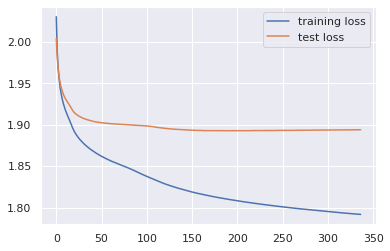

In [175]:
# prev best 1.61
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
x = np.arange(len(training_losses))
plt.plot(x, training_losses, label = 'training loss')
plt.plot(x, test_losses, label = 'test loss')
plt.legend()

In [176]:
print(confusion_matrix[-1])

tensor([[2.7000e+02, 3.9100e+02, 1.8500e+02, 4.5000e+01, 1.7200e+02, 0.0000e+00,
         2.0000e+00, 0.0000e+00],
        [1.2300e+02, 1.2230e+03, 2.7600e+02, 8.4000e+01, 4.3300e+02, 0.0000e+00,
         3.0000e+00, 0.0000e+00],
        [1.2400e+02, 5.8900e+02, 5.0000e+02, 4.7000e+01, 2.5300e+02, 0.0000e+00,
         1.0000e+00, 0.0000e+00],
        [4.4000e+01, 4.2000e+02, 8.6000e+01, 1.6000e+02, 2.0900e+02, 0.0000e+00,
         1.0000e+00, 0.0000e+00],
        [8.7000e+01, 6.7300e+02, 1.5900e+02, 7.7000e+01, 6.7900e+02, 3.0000e+00,
         2.0000e+00, 0.0000e+00],
        [6.0000e+00, 9.4000e+01, 2.4000e+01, 7.0000e+00, 4.0000e+01, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.3000e+01, 7.9000e+01, 3.2000e+01, 1.4000e+01, 3.5000e+01, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [5.0000e+00, 3.5000e+01, 7.0000e+00, 2.0000e+00, 2.0000e+01, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])


In [177]:
featureExtractor.load_state_dict(torch.load("lw.pt"))

<All keys matched successfully>

In [203]:
example1 = "presentation"
words1 = example1.split(" ")
seq1 = []
for word in words1:
    if word in corpora.index_word:
        seq1.append(corpora.word_index[word])
    else:
        seq1.append(0)
seq1 = torch.tensor([seq1])
z = featureExtractor.forward(seq1)
d = torch.softmax(z,dim=-1)
print("Example: ", example1, "\nsq: ", seq1, "\nprediction: ", d)

Example:  presentation 
sq:  tensor([[0]]) 
prediction:  tensor([[1.3856e-01, 3.0496e-01, 1.8434e-01, 1.3244e-01, 2.3729e-01, 3.6552e-05,
         2.3310e-03, 3.6433e-05]], grad_fn=<SoftmaxBackward0>)


In [135]:
kept

['problems with friends',
 'ongoing depression',
 'breakup with partner',
 'academic pressure',
 'job crisis',
 'Sleep Problems',
 'Issues with Families',
 'Alcohol Abuse']